## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Step 0: Import Packages

In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import os
import glob
import math
%matplotlib inline

## Step 1: Compute the camera calibration using chessboard images

### chessboard images corner finding

In [28]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
# for fname in images:
#     img = cv2.imread(fname)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#     # Find the chessboard corners
#     ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

#     # If found, add object points, image points
#     if ret == True:
#         objpoints.append(objp)
#         imgpoints.append(corners)

#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(200)

# cv2.destroyAllWindows()

### Calculate distortion coefficients and save paramter

In [29]:
# img = cv2.imread('./camera_cal/test_image.jpg')
# img_size = (img.shape[1], img.shape[0])
# print('This image is:', type(img), 'with dimensions:', img.shape)

# # Do camera calibration given object points and image points
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# save_file = "./camera_cal/wide_dist_pickle.p"
# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# pickle.dump( dist_pickle, open(save_file , "wb" ) )

### Restore distortion coefficients, and test undistortion on an image!

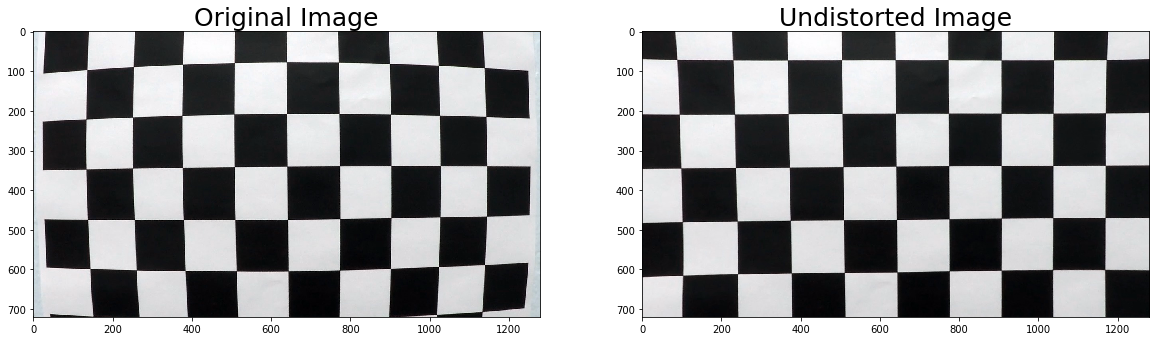

In [30]:
save_file = "./camera_cal/wide_dist_pickle.p"

with open(save_file, mode='rb') as f:
    dist_pickle = pickle.load(f)

mtx = dist_pickle["mtx"] 
dist = dist_pickle["dist"] 

# Test undistortion on an image
img = cv2.imread('./camera_cal/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)

## Step 2: Apply a distortion correction to raw images

### List Tested Images

In [31]:
os.listdir("test_images/")

['frame1041.jpg',
 'frame1139.jpg',
 'frame120.jpg',
 'frame133.jpg',
 'frame604.jpg',
 'frame72.jpg',
 'straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

### Show Images Function

In [32]:
def show_images(images,lable=None,cols = 3,cmap=None):
    
    rows = (len(images)+cols-1)//cols 
    
    plt.figure(figsize=(14, 14))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        # use gray scale color map if there is only one channel   
        showimage_shape = image.shape

        if len(showimage_shape) == 2: 
            cmap = "gray"
        elif  showimage_shape[2] == 1:
            image = image[:,:,0]
            cmap = "gray"
        
        plt.imshow(image, cmap=cmap)
        if lable != None and lable[i] != None:
            plt.title(lable[i],fontsize=12)
#         plt.xticks([])
#         plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

### Show raw Images

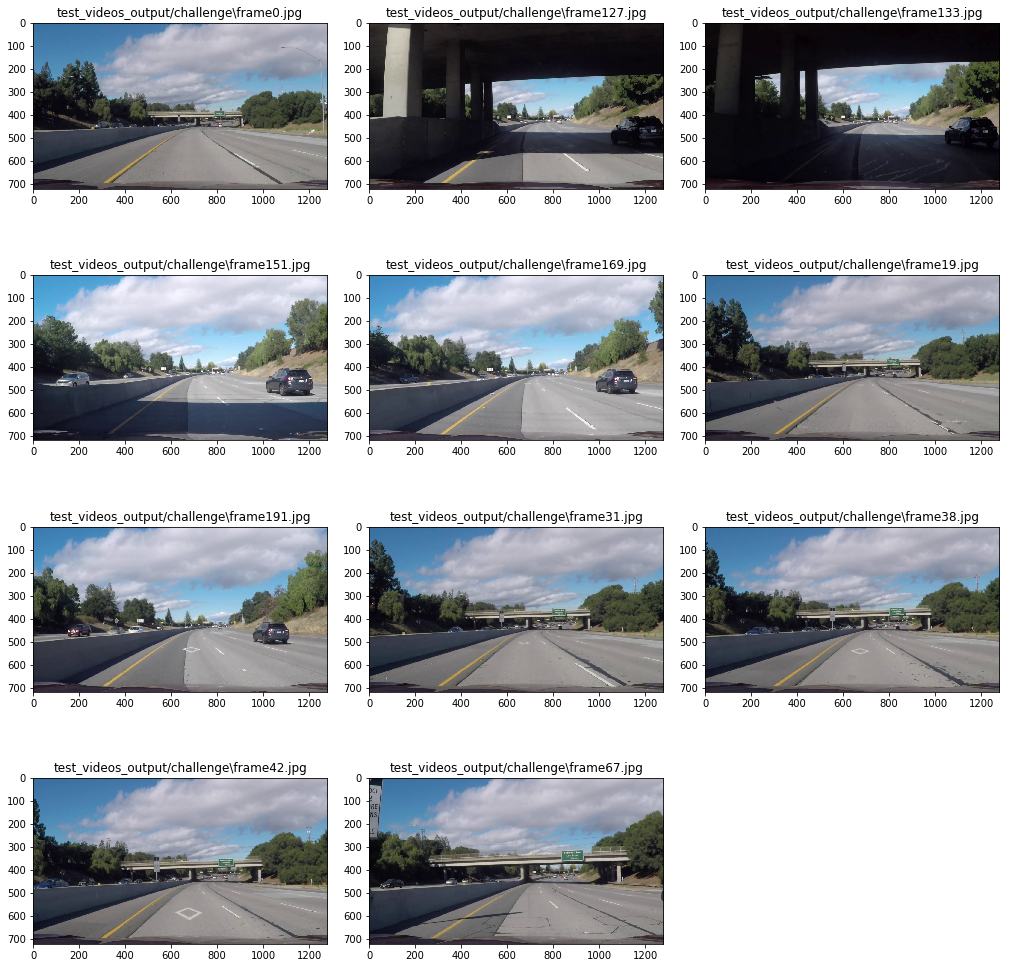

In [69]:
# read_images = [[plt.imread(path),path] for path in glob.glob('test_images/*.jpg')]
read_images = [[plt.imread(path),path] for path in glob.glob('test_videos_output/challenge/*.jpg')]


test_images = [s[0] for s in read_images]
test_images_label = [s[1] for s in read_images]

show_images(test_images,test_images_label)

### Undistort Images

In [34]:
def imageundistort(img,mtx=mtx,dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

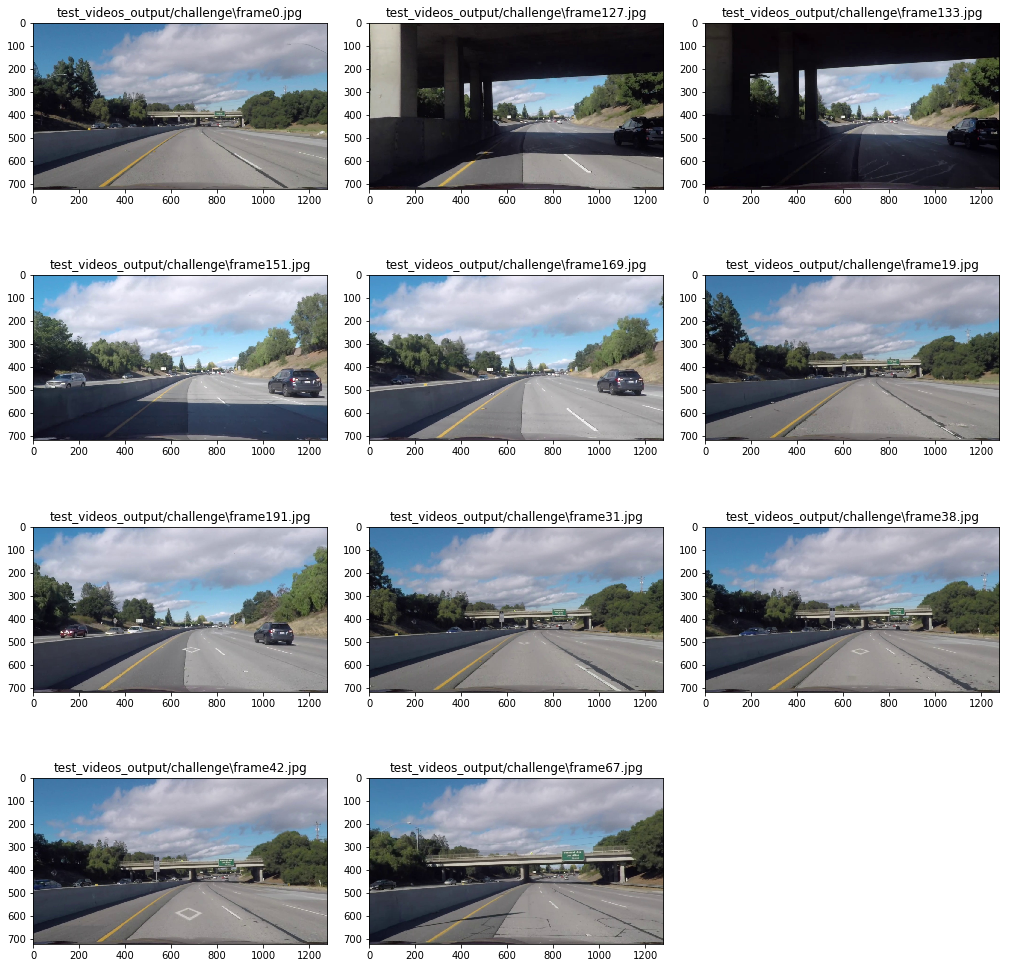

In [70]:
undistort_images = list(map(imageundistort, test_images))

show_images(undistort_images,test_images_label)

## Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

### color transforms:HSL HSV Lab Channel Show

In [36]:
def channelsplit(img):
    channel_images=[]
    channel_images_label=[]
    
    #origin RGB image
    channel_images.append(img)
    channel_images_label.append('Original Image')
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    channel_images.append(gray)
    channel_images_label.append('gray Image')  
    
    grayequalizeHist = cv2.equalizeHist(gray) 
    channel_images.append(grayequalizeHist)
    channel_images_label.append('EqualizeHist Image') 
    
    #HLS image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    channel_images.append(h)
    channel_images_label.append('HLS: H Channel Image') 
    channel_images.append(l)
    channel_images_label.append('HLS: L Channel Image') 
    channel_images.append(s)
    channel_images_label.append('HLS: S Channel Image') 
    
    #HSV image
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    channel_images.append(h)
    channel_images_label.append('HSV: H Channel Image') 
    channel_images.append(s)
    channel_images_label.append('HSV: S Channel Image') 
    channel_images.append(v)
    channel_images_label.append('HSV: V Channel Image') 
    
    #Lab image
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    channel_images.append(l)
    channel_images_label.append('Lab: L Channel Image') 
    channel_images.append(a)
    channel_images_label.append('Lab: a Channel Image') 
    channel_images.append(b)
    channel_images_label.append('Lab: b Channel Image') 
    
    return channel_images,channel_images_label

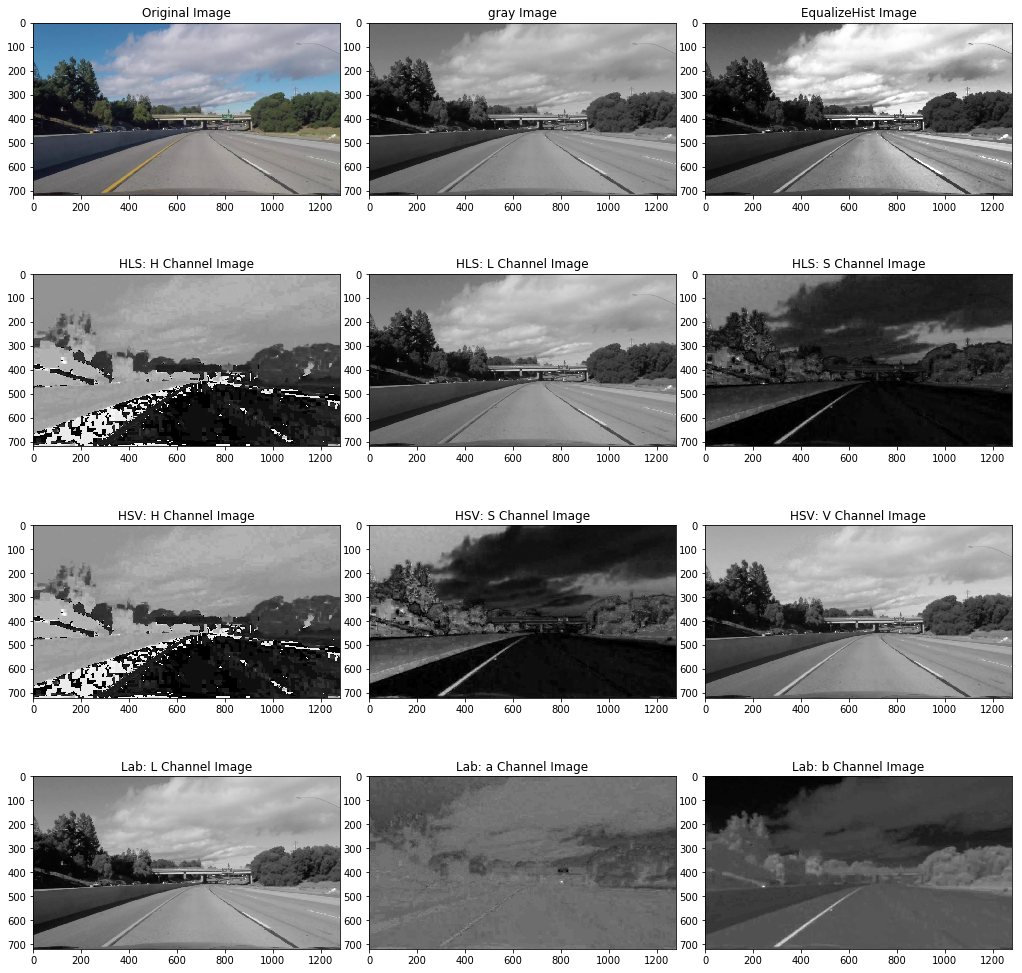

In [71]:
images,label = channelsplit(undistort_images[0])

show_images(images,label)

### Color threshold

In [38]:
def hsv_thresh(img, v_thresh=(200, 255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    return binary_output

def hls_thresh(img, s_thresh=(190, 255)):

    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hsl[:,:,1]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return binary_output

def lab_thresh(img, b_thresh=(150, 255)):    
    Lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = Lab[:,:,2]
    
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    return binary_output

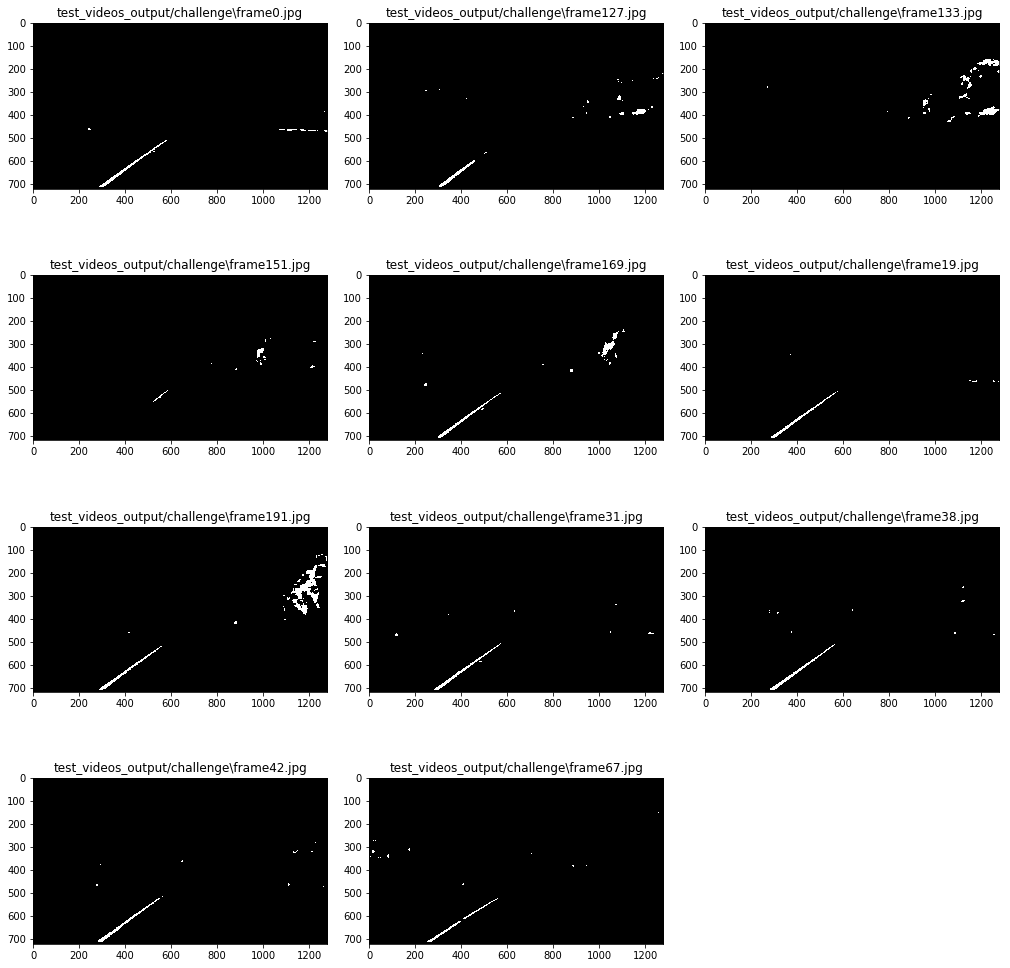

In [78]:
color_binary = list(map(lab_thresh, undistort_images))

show_images(color_binary,test_images_label)

### gradients: sobel

In [92]:
def sobel_thresh(img, orient='x',sobel_thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=5))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=5))
        
    #Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255)):
	"""
	Return the magnitude of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Take both Sobel x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Calculate the gradient magnitude
	gradmag = np.sqrt(sobelx**2 + sobely**2)
	# Rescale to 8 bit
	scale_factor = np.max(gradmag)/255
	gradmag = (gradmag/scale_factor).astype(np.uint8)
	# Create a binary image of ones where threshold is met, zeros otherwise
	binary_output = np.zeros_like(gradmag)
	binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

	# Return the binary image
	return binary_output


def dir_threshold(img, sobel_kernel=15, thresh=(0.7, np.pi/2)):
	"""
	Return the direction of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Calculate the x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Take the absolute value of the gradient direction,
	# apply a threshold, and create a binary image result
	absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
	binary_output =  np.zeros_like(absgraddir)
	binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

	# Return the binary image
	return binary_output

def pipeline1(img):
    mag_thresh_bin = mag_thresh(img)
    dir_thresh_bin = dir_threshold(img)
    
    color_binary = np.dstack(( np.zeros_like(mag_thresh_bin), mag_thresh_bin, dir_thresh_bin)) 

    combined_binary = np.zeros_like(mag_thresh_bin)
    combined_binary[ (mag_thresh_bin == 1) & (dir_thresh_bin == 1)] = 1
    
    return combined_binary

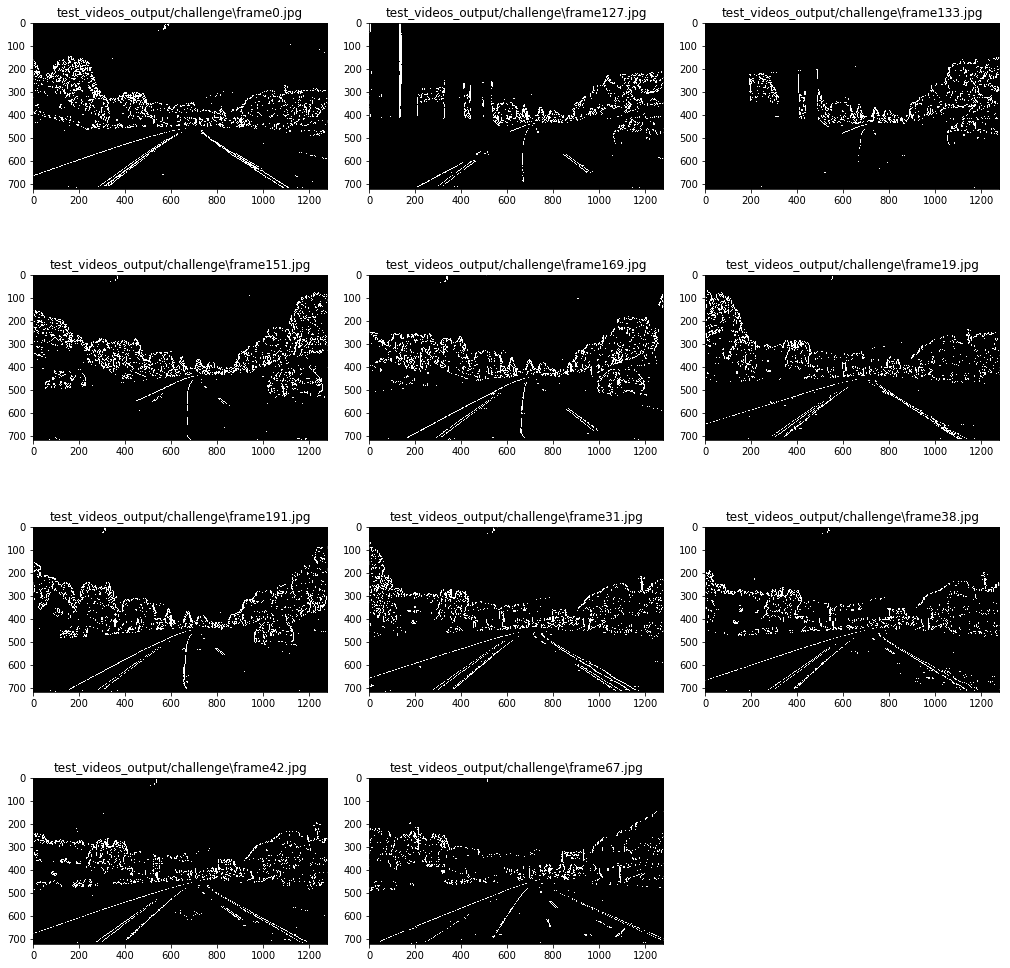

In [93]:
gradient_binary = list(map(sobel_thresh, undistort_images))

show_images(gradient_binary,test_images_label)

###  Combined thresholded binary

In [100]:
def pipeline(img):
    sobel_thresh_bin = sobel_thresh(img)
    hsv_thresh_bin = hsv_thresh(img)
    hsl_thresh_bin = hls_thresh(img)
    lab_thresh_bin = lab_thresh(img)
    
    color_binary = np.dstack(( np.zeros_like(sobel_thresh_bin), sobel_thresh_bin, hsv_thresh_bin)) *255

    combined_binary = np.zeros_like(sobel_thresh_bin)
    combined_binary[ (sobel_thresh_bin == 1) | (hsv_thresh_bin == 1) | (lab_thresh_bin == 1)] = 1
    
    return combined_binary

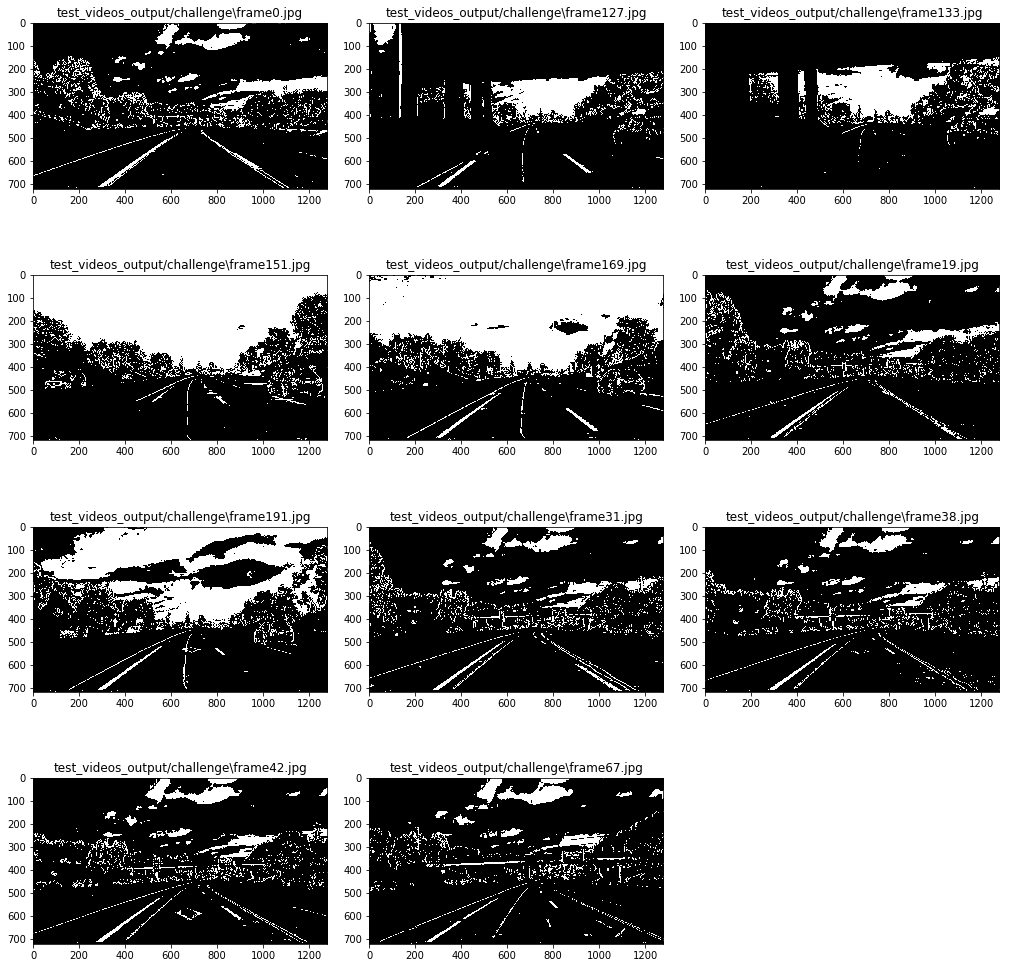

In [101]:
filted_binary = list(map(pipeline, undistort_images))

show_images(filted_binary,test_images_label)


## Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").

### Perspective Transformed View Point

In [102]:
# src = np.float32([[555,480],[735,480],[1120,720],[210,720]])
# dst = np.float32([[210,0],[1120,0],[1120,720],[210,720]])

src = np.float32([[525,500],[765,500],[1120,720],[210,720]])
dst = np.float32([[210,0],[1120,0],[1120,720],[210,720]])

# src = np.float32([[555,480],[735,480],[1120,720],[210,720]])
# dst = np.float32([[210,100],[1120,100],[1120,720],[210,720]])

# src = np.float32([[460,550],[850,550],[1120,720],[210,720]])
# dst = np.float32([[210,0],[1120,0],[1120,720],[210,720]])

# src = np.float32([[555,480],[735,480],[1120,720],[210,720]])
# dst = np.float32([[210,0],[1120,0],[1120,720],[210,720]])

# src = np.float32(\
#     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],\
#      [((img_size[0] / 6) - 10), img_size[1]],\
#      [(img_size[0] * 5 / 6) + 60, img_size[1]],\
#      [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]) 

# dst = np.float32(\
#     [[(img_size[0] / 4), 0],\
#      [(img_size[0] / 4), img_size[1]],\
#      [(img_size[0] * 3 / 4), img_size[1]],\
#      [(img_size[0] * 3 / 4), 0]])


def warp(img,src=src,dst=dst):
    img_size = (img.shape[1],img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

print("source view point")
print(src)
print("Transformed view point")
print(dst)



source view point
[[  525.   500.]
 [  765.   500.]
 [ 1120.   720.]
 [  210.   720.]]
Transformed view point
[[  210.     0.]
 [ 1120.     0.]
 [ 1120.   720.]
 [  210.   720.]]


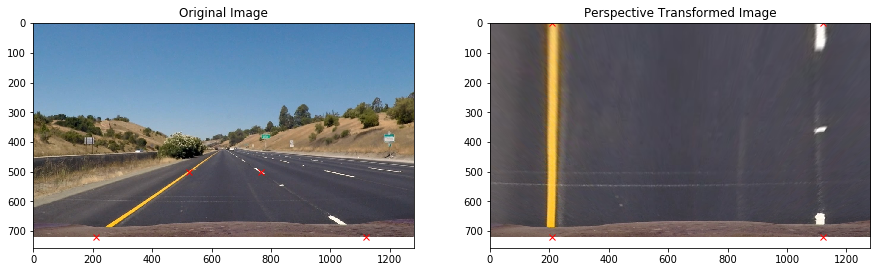

In [103]:
#reading in an image
straightimage = mpimg.imread('test_images/straight_lines1.jpg')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(straightimage) 
plt.plot(src[:,0], src[:,1], 'rx')
plt.title('Original Image')

plt.subplot(1, 2, 2)
warpstraightimage = warp(straightimage)
plt.imshow(warpstraightimage) 
plt.plot(dst[:,0], dst[:,1], 'rx')
plt.title('Perspective Transformed Image')

### Lane marked Perspective Transform

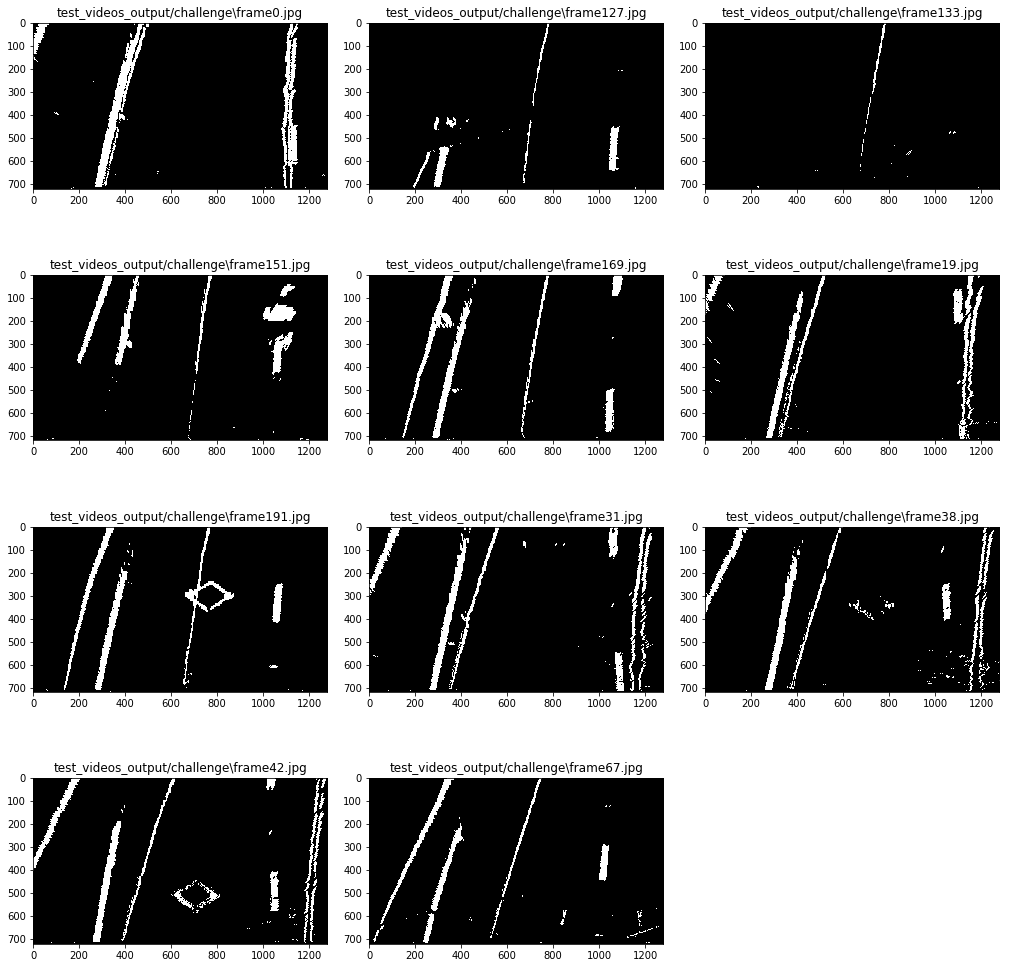

In [104]:
warp_images = list(map(warp, filted_binary))

show_images(warp_images,test_images_label)

## Step 5: Detect lane pixels and fit to find the lane boundary.

### Line Finding Method:Peaks in a Histogram

In [105]:
def show_histogram(images,cols = 3):
    rows = (len(images)+cols-1)//cols 
    
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        plt.plot(histogram)
    
    plt.show()

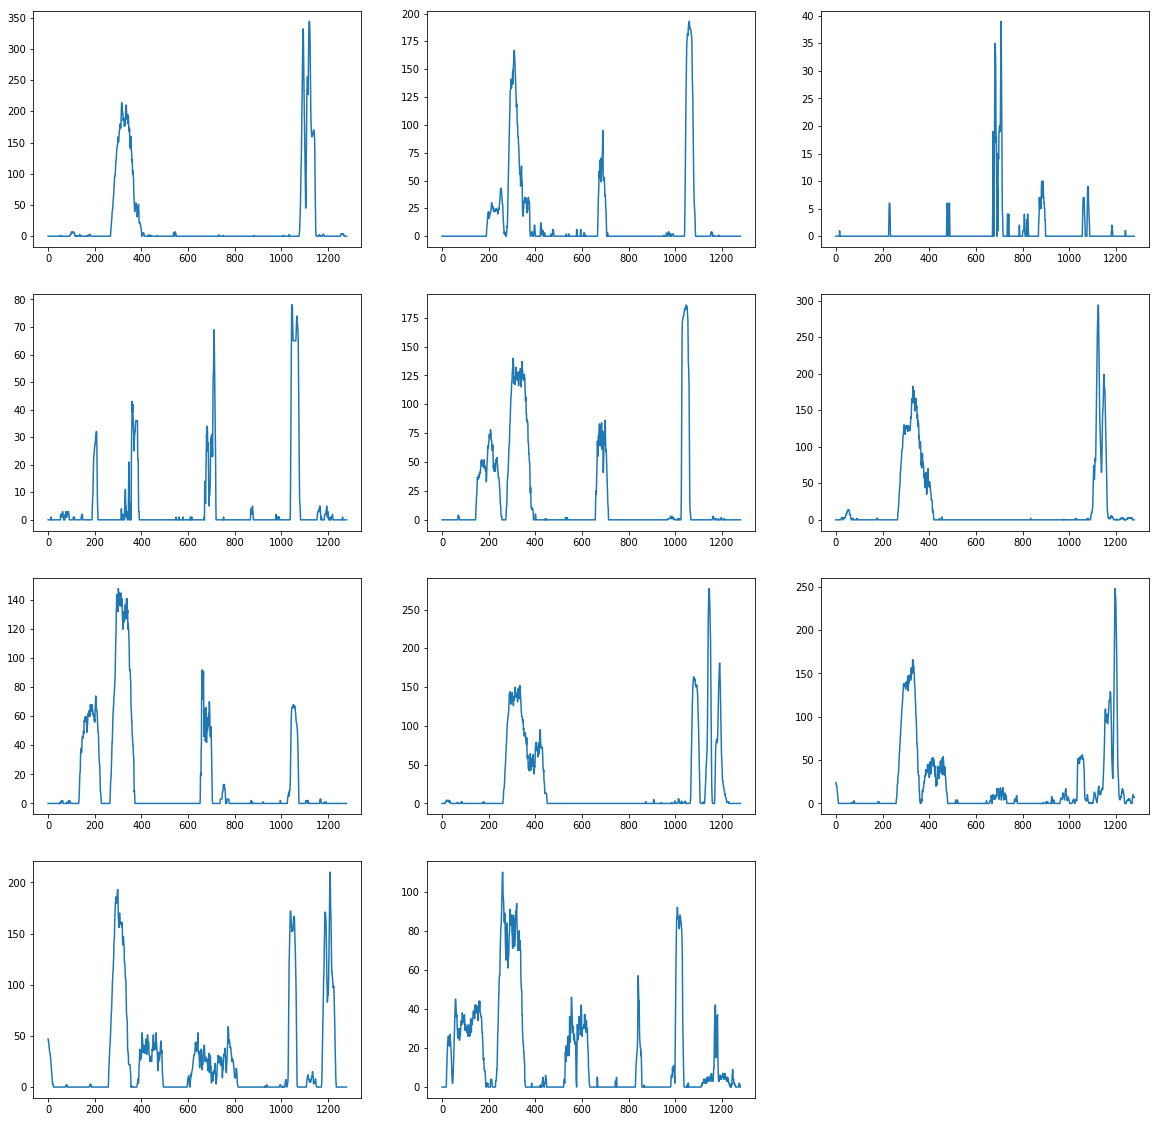

In [106]:
show_histogram(warp_images)

In [107]:
def recognize_lane(binary_warped,nwindows = 9,margin = 100,minpix = 50,bias=0.2):
    """
    margin: Set the width of the windows +/- margin
    minpix: Set minimum number of pixels found to recenter window
    bias: left start nad right start offest from middpoint
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    
    leftstart = int((1-bias)*midpoint)
    rightstart = int((1+bias)*midpoint)
    
    leftx_base = np.argmax(histogram[:leftstart])
    rightx_base = np.argmax(histogram[rightstart:]) + rightstart

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] 
    
    left_fit = None
    right_fit = None
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
     # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        p_left = np.poly1d(left_fit)
        left_fitx = p_left(ploty)
        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=5)
        
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        p_right = np.poly1d(right_fit)
        right_fitx = p_right(ploty)   
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=5)
    
    return out_img,left_fit,right_fit

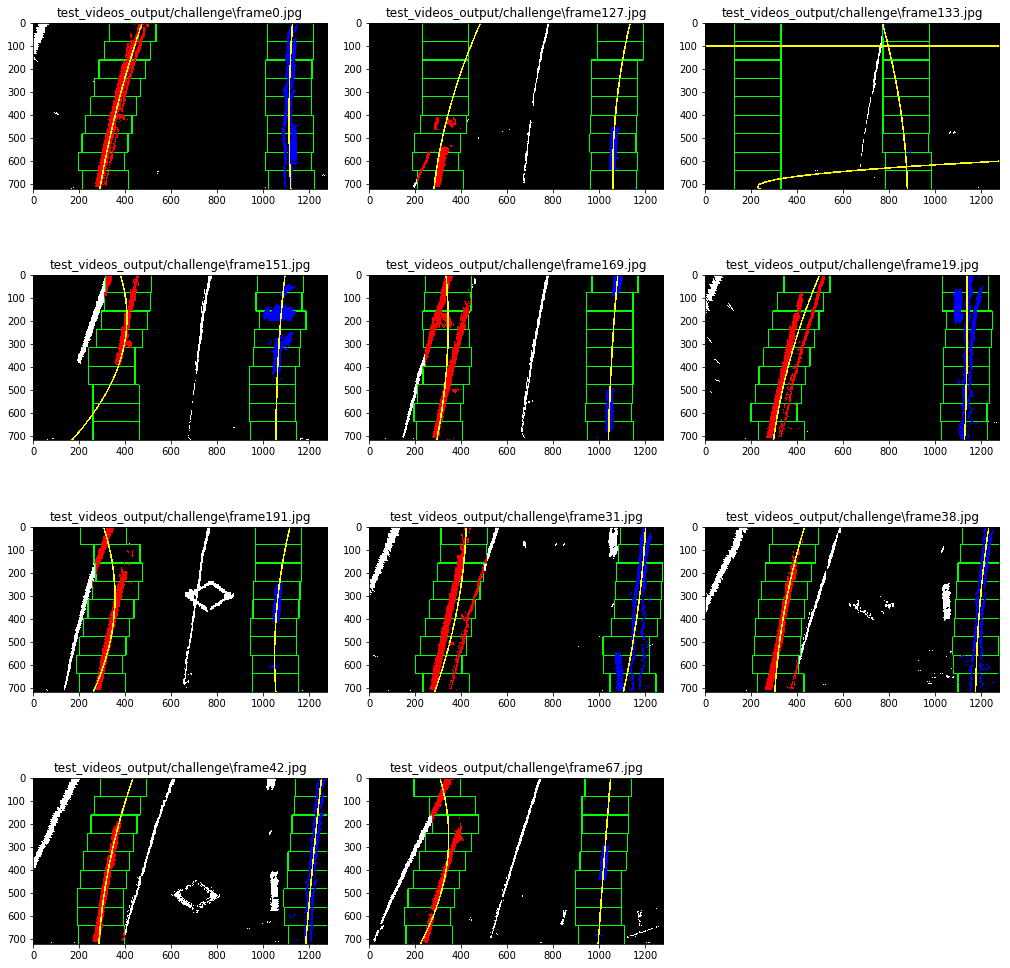

In [108]:
recogin_images = list(map(recognize_lane, warp_images))

fittedimge = [s[0] for s in recogin_images]
left_fit = [s[1] for s in recogin_images]
right_fit = [s[2] for s in recogin_images]

show_images(fittedimge,test_images_label)

In [51]:
def recognize_fitted_lane(binary_warped,left_fit,right_fit,nwindows = 9,margin = 100,minpix = 50):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_new_fit = None
    right_new_fit = None
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Fit a second order polynomial to each
    
    if len(leftx) != 0:
        left_new_fit = np.polyfit(lefty, leftx, 2)
        p_left = np.poly1d(left_new_fit)
        left_fitx = p_left(ploty)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=5)
            
    if len(rightx) != 0:
        right_new_fit = np.polyfit(righty, rightx, 2)
        p_right = np.poly1d(right_new_fit)
        right_fitx = p_right(ploty)  
         # Generate a polygon to illustrate the search window area
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
    
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
      
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=5)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_new_fit,right_new_fit

In [52]:
recogin_images = list(map(recognize_fitted_lane, warp_images,left_fit,right_fit))

fittedimge = [s[0] for s in recogin_images]
left_fit = [s[1] for s in recogin_images]
right_fit = [s[2] for s in recogin_images]

show_images(fittedimge,test_images_label)

TypeError: 'NoneType' object is not subscriptable

## Setp 6: Determine the curvature of the lane and vehicle position with respect to center.

### Measure Lane Curvature

In [53]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [54]:
def measuring_curvature(binary_warped,line_fit):

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    line_fitx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    line_fit_cr = np.polyfit(ploty*ym_per_pix, line_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    cal_curverad = ((1 + (2*line_fit_cr[0]*y_eval*ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    
    return cal_curverad

### Measure vehicle position with respect to center

In [55]:
def center_offest(binary_warped,line_fit):
    
    y_eval = binary_warped.shape[0]-1
    
    p_line = np.poly1d(line_fit)
    line_fitx = p_line(y_eval)
    
    center_offset_meter = (line_fitx-binary_warped.shape[1]/2)*xm_per_pix
    
    return center_offset_meter

## Setp 7: Warp the detected lane boundaries back onto the original image.

In [56]:
def unwarp(img,left_fit,right_fit,src=src,dst=dst):
    img_size = (img.shape[1],img.shape[0])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create an image to draw the lines on
#     warp_zero = np.zeros_like(warp_images[0]).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

In [57]:
unwarp_images = list(map(unwarp, undistort_images,left_fit,right_fit))

show_images(unwarp_images,test_images_label)

TypeError: 'NoneType' object is not subscriptable

## Setp 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [58]:
def draw_estimation(img,left_fit,right_fit):
    
    left_cur = measuring_curvature(img,left_fit)
    right_cur = measuring_curvature(img,right_fit)
    
    left_center_offest_meter = center_offest(img,left_fit)
    right_center_offest_meter = center_offest(img,right_fit)
    center_offest_meter = (left_center_offest_meter + right_center_offest_meter)/2.0
        
    cv2.putText(img,'center offest:{:.2f}m'.format(left_cur),(10,60),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)
    cv2.putText(img,'left curvature:{:.2f}m'.format(right_cur),(10,130),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)
    cv2.putText(img,'right curvature:{:.2f}m'.format(center_offest_meter),(10,200),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)
    
    return img

In [59]:
res_images= list(map(draw_estimation, unwarp_images,left_fit,right_fit))

show_images(res_images,test_images_label)

NameError: name 'unwarp_images' is not defined

## Image Picture Process with Debug

In [60]:
def image_process_show(image, recent_leftfitted=None, recent_rightfitted=None, debugcombined = True,framenumber = None):
    
    undistort_images = imageundistort(image)
    
    pipe_images = pipeline(undistort_images)
    
    warp_images = warp(pipe_images)
    
    if recent_leftfitted != None and recent_rightfitted != None:
        fittedimg,recent_leftfitted,recent_rightfitted = recognize_fitted_lane(warp_images,\
                                                                                      recent_leftfitted,recent_rightfitted)
    else:
        fittedimg,recent_leftfitted,recent_rightfitted = recognize_lane(warp_images)
           
    unwarp_images = unwarp(undistort_images,recent_leftfitted,recent_rightfitted)
    
    res_images = draw_estimation(unwarp_images,recent_leftfitted,recent_rightfitted)
    
    if debugcombined == True:
        # Calculate the size of screens
        result_screen_w = unwarp_images.shape[1]
        result_screen_h = unwarp_images.shape[0]
        debug_screen_w = np.int(result_screen_w/3)
        debug_screen_h = np.int(result_screen_h/3)
        screen_w = result_screen_w + debug_screen_w
        screen_h = result_screen_h
        
        # Assign result image to the screen
        #show screen
        screen = np.zeros((screen_h,screen_w,3),dtype=np.uint8)
        
        if framenumber != None:
            cv2.putText(unwarp_images,'frame index:{:}'.format(framenumber),(10,270),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)
        
        screen[0:result_screen_h,0:result_screen_w] = res_images
        # Assign debug image to the screen
        debug_img_1 = np.dstack((pipe_images,pipe_images,pipe_images))*255
        screen[0:debug_screen_h,result_screen_w:,:] = cv2.resize(debug_img_1,(debug_screen_w,debug_screen_h))
        
        debug_img_2 = np.dstack((warp_images,warp_images,warp_images))*255
        screen[debug_screen_h : debug_screen_h*2,result_screen_w:,:] =cv2.resize(debug_img_2,(debug_screen_w,debug_screen_h))
        
        debug_img_3 = fittedimg
        screen[debug_screen_h*2 : debug_screen_h*3,result_screen_w:,:] =cv2.resize(debug_img_3,(debug_screen_w,debug_screen_h))
        
        return screen,recent_leftfitted,recent_rightfitted
    else:
        return unwarp_images,recent_leftfitted,recent_rightfitted

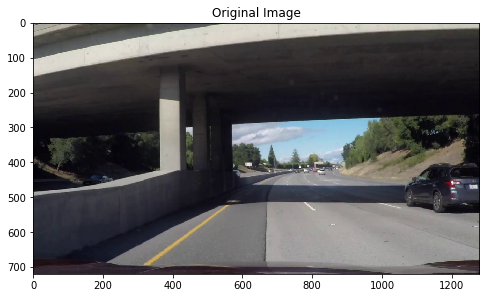

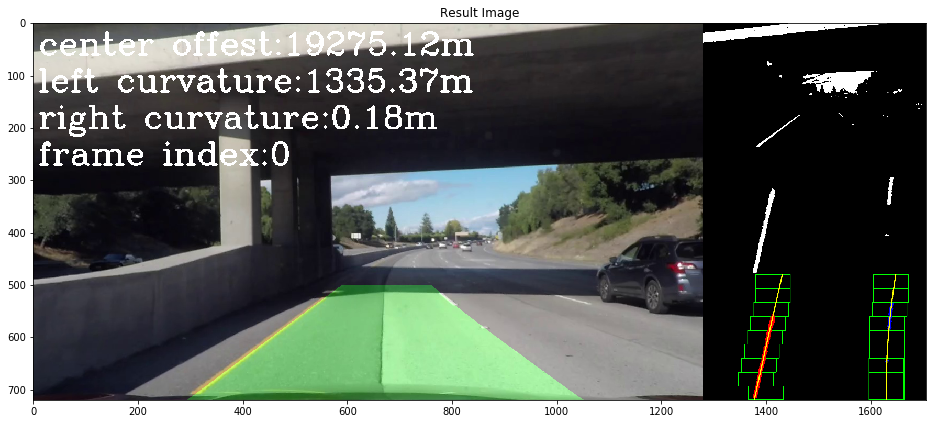

In [61]:
#reading in an image
# image_process_test_image = mpimg.imread('test_images/straight_lines1.jpg')
image_process_test_image = test_images[2]

plt.figure(figsize=(8, 8))
plt.imshow(image_process_test_image) 
plt.title('Original Image')

plt.figure(figsize=(16, 16))
warp_image_process_test_image = image_process_show(image_process_test_image,framenumber=0)
plt.imshow(warp_image_process_test_image[0]) 
plt.title('Result Image')

## Video Process with Debug

### Define Line Class

In [62]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self,maxlen=10):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen = maxlen) 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None

    def update_detected(self,img,detected=True):
        self.detected = detected  
        #if lane lines do not dectect correctly,remove from deque
        if self.detected == False and len(self.recent_xfitted) > 0:
            self.recent_xfitted.pop()
            self.update_bestx(img)
            self.update_best_fit(img)
            
    def update_recent_xfitted(self,img):
        yvals = np.linspace(0,img.shape[0]-1,img.shape[0])
        current_xval = self.current_fit[0]*yvals**2 + self.current_fit[1]*yvals + self.current_fit[2]
        self.recent_xfitted.append(current_xval)

    def update_bestx(self,img):
        if len(self.recent_xfitted) > 0:
            self.bestx = np.mean(self.recent_xfitted,axis=0)
        else:
            self.bestx = None
        
    def update_best_fit(self,img):
        if self.bestx != None:
            yvals = np.linspace(0, img.shape[0]-1, img.shape[0] )
            line_new_fit = np.polyfit(yvals, self.bestx, 2)
            self.best_fit = line_new_fit
        else:
            self.best_fit = None
    
    def update_current_fit(self,fit):
        self.current_fit = fit
        
    def update_radius_of_curvature(self,img):
        self.radius_of_curvature = measuring_curvature(img,self.current_fit)
    
    def update_line_base_pos(self,img):
        self.line_base_pos = center_offest(img,self.current_fit)   
        
    def update_diffs(self):
        self.diffs = self.current_fit - self.best_fit
        
    def upadate_data(self,img,fit):
        self.update_current_fit(fit)
        self.update_recent_xfitted(img)
        self.update_bestx(img)
        self.update_best_fit(img)
        self.update_diffs()
        self.update_radius_of_curvature(img)
        self.update_line_base_pos(img)

### Sanity Check

* Checking that they have similiar curvature
* Checking that they are seperated by approximately the right distance horizontally
* Checking that they are roughly parallel

In [63]:
curv_ratio_threshold = 25
distance_min_diff_bias = 400 #pixel in x dimension
distance_pos_max_diff_bias = 1200 #pixel in x dimension
distance_deviation_threshold = 300 #pixel in x dimension

def sanity_check(left_line,right_line):
    #Checking that they have similiar curvature
    left_radius_of_curvature = left_line.radius_of_curvature
    right_radius_of_curvature = right_line.radius_of_curvature
    
    curvature_ratio = left_radius_of_curvature/right_radius_of_curvature
    if curvature_ratio > curv_ratio_threshold or curvature_ratio <1.0/curv_ratio_threshold:
        print("curvature_ratio:")
        print(curvature_ratio)
        return False
    
    #Checking that they are seperated by approximately the right distance horizontally
    left_fitx = left_line.recent_xfitted[0]
    right_fitx = right_line.recent_xfitted[0]
    
    lane_horizon_distance = right_fitx - left_fitx
    lane_distance_max = max(lane_horizon_distance)
    lane_distance_min = min(lane_horizon_distance)
    
    if lane_distance_min < distance_min_diff_bias or lane_distance_max > distance_pos_max_diff_bias:
        print("lane_distance:")
        print(lane_distance_max)
        print(lane_distance_min)
        return False
    
    # Checking that they are roughly parallel
    distance_deviation = np.std(lane_horizon_distance)
    if distance_deviation >= distance_deviation_threshold:
        print("distance_deviation:")
        print(distance_deviation)
        return False
    
#     left_line_diff = np.absolute(left_line.diffs)
#     if left_line_diff[0] > 0.01 or left_line_diff[1] > 0.3 or left_line_diff[2] > 150:
#         print("left_line_diff:")
#         print(left_line_diff)
#         return False
    
#     right_line_diff = np.absolute(right_line.diffs)
#     if right_line_diff[0] > 0.01 or right_line_diff[1] > 0.3 or right_line_diff[2] > 150:
#         print("right_line_diff:")
#         print(right_line_diff)
#         return False
                
    return True

In [64]:
def line_find_process(image,left_line,right_line):
    if left_line.best_fit != None and right_line.best_fit != None:
        fittedimg,recent_leftfitted,recent_rightfitted = recognize_fitted_lane(image,\
                                                                                      left_line.best_fit,right_line.best_fit)
    else:
        fittedimg,recent_leftfitted,recent_rightfitted = recognize_lane(image)
    
    if recent_leftfitted != None and recent_rightfitted != None:
        left_line.upadate_data(image,recent_leftfitted)
        right_line.upadate_data(image,recent_rightfitted)

        if sanity_check(left_line,right_line):
            left_line.update_detected(image,True)
            right_line.update_detected(image,True)
        else:
            left_line.update_detected(image,False)
            right_line.update_detected(image,False)
    else:
        left_line.update_detected(image,False)
        right_line.update_detected(image,False)
    
    return fittedimg,left_line.best_fit,right_line.best_fit  

In [84]:
# Define left and right lines for detection
left_lines = Line()
right_lines = Line()

def video_process_show(image,debugcombined = True,framenumber = None):
    
    undistort_images = imageundistort(image)
    
    pipe_images = pipeline(undistort_images)
    
    warp_images = warp(pipe_images)
    
    fittedimg,recent_leftfitted,recent_rightfitted = line_find_process(warp_images,left_lines,right_lines)
           
    unwarp_images = unwarp(undistort_images,recent_leftfitted,recent_rightfitted)
    
    res_images = draw_estimation(unwarp_images,recent_leftfitted,recent_rightfitted)
    
    if debugcombined == True:
        # Calculate the size of screens
        result_screen_w = unwarp_images.shape[1]
        result_screen_h = unwarp_images.shape[0]
        debug_screen_w = np.int(result_screen_w/3)
        debug_screen_h = np.int(result_screen_h/3)
        screen_w = result_screen_w + debug_screen_w
        screen_h = result_screen_h
        
        # Assign result image to the screen
        #show screen
        screen = np.zeros((screen_h,screen_w,3),dtype=np.uint8)
        
        if framenumber != None:
            cv2.putText(unwarp_images,'frame index:{:}'.format(framenumber),(10,270),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),3)
        
        screen[0:result_screen_h,0:result_screen_w] = res_images
        # Assign debug image to the screen
        debug_img_1 = np.dstack((pipe_images,pipe_images,pipe_images))*255
        screen[0:debug_screen_h,result_screen_w:,:] = cv2.resize(debug_img_1,(debug_screen_w,debug_screen_h))
        
        debug_img_2 = np.dstack((warp_images,warp_images,warp_images))*255
        screen[debug_screen_h : debug_screen_h*2,result_screen_w:,:] =cv2.resize(debug_img_2,(debug_screen_w,debug_screen_h))
        
        debug_img_3 = fittedimg
        screen[debug_screen_h*2 : debug_screen_h*3,result_screen_w:,:] =cv2.resize(debug_img_3,(debug_screen_w,debug_screen_h))
        
        return screen
    else:
        return unwarp_images

## Test on Videos

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Test on Project Videos

In [ ]:
project_output = 'test_videos_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
L = Line()
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(video_process_show) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="450" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Test on challenge Videos

In [85]:
challenge_source = "test_videos/challenge_video.mp4"
challenge_output = 'test_videos_output/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(challenge_source)
L = Line()
white_clip = clip1.fl_image(video_process_show) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_output.mp4
[MoviePy] Writing video test_videos_output/challenge_video_output.mp4



  1%|          | 6/485 [00:00<00:43, 11.02it/s]

curvature_ratio:
545.488871898
curvature_ratio:
1.71544904691e-09



  2%|▏         | 8/485 [00:00<00:44, 10.80it/s]

curvature_ratio:
79.4470465668



  2%|▏         | 10/485 [00:00<00:44, 10.78it/s]

curvature_ratio:
141.876630945



  2%|▏         | 12/485 [00:01<00:43, 10.98it/s]

curvature_ratio:
83.3485290838



  3%|▎         | 13/485 [00:01<00:46, 10.10it/s]

curvature_ratio:
41.025479721



  4%|▍         | 19/485 [00:01<00:43, 10.63it/s]

curvature_ratio:
126.077176303



  4%|▍         | 21/485 [00:01<00:43, 10.61it/s]

lane_distance:
5867.71763245
700.358032983



  5%|▍         | 23/485 [00:02<00:43, 10.58it/s]

lane_distance:
5867.71763245
700.358032983
lane_distance:
5867.71763245
700.358032983



  5%|▌         | 25/485 [00:02<00:44, 10.39it/s]

curvature_ratio:
38.4152642145
curvature_ratio:
48.2147965994



  6%|▌         | 27/485 [00:02<00:44, 10.19it/s]

curvature_ratio:
105.059671024



  6%|▌         | 29/485 [00:02<00:44, 10.36it/s]

curvature_ratio:
193.917204666



  6%|▋         | 31/485 [00:02<00:43, 10.48it/s]

curvature_ratio:
282.573952034
lane_distance:
5867.71763245
700.358032983



  7%|▋         | 33/485 [00:03<00:43, 10.46it/s]

lane_distance:
5867.71763245
700.358032983
curvature_ratio:
417.752941829



  7%|▋         | 35/485 [00:03<00:43, 10.29it/s]

lane_distance:
5867.71763245
700.358032983
lane_distance:
5867.71763245
700.358032983



  8%|▊         | 37/485 [00:03<00:43, 10.21it/s]

curvature_ratio:
45.9216697283
curvature_ratio:
385.950570506



  8%|▊         | 39/485 [00:03<00:43, 10.26it/s]

curvature_ratio:
139.760389811
lane_distance:
5867.71763245
700.358032983



  8%|▊         | 41/485 [00:03<00:43, 10.30it/s]

lane_distance:
5867.71763245
700.358032983



  9%|▉         | 43/485 [00:04<00:42, 10.39it/s]

curvature_ratio:
1.2329350581e-09



  9%|▉         | 45/485 [00:04<00:41, 10.61it/s]

curvature_ratio:
33.9517570285



 10%|▉         | 47/485 [00:04<00:42, 10.29it/s]

lane_distance:
5867.71763245
700.358032983
lane_distance:
5867.71763245
700.358032983



 10%|█         | 49/485 [00:04<00:43, 10.10it/s]

lane_distance:
5867.71763245
700.358032983
curvature_ratio:
25.0319809369



 11%|█         | 51/485 [00:04<00:44,  9.66it/s]

curvature_ratio:
51.5535707657



 11%|█         | 52/485 [00:05<00:45,  9.56it/s]

lane_distance:
5867.71763245
700.358032983



 11%|█         | 53/485 [00:05<00:44,  9.68it/s]

lane_distance:
5867.71763245
700.358032983



 12%|█▏        | 57/485 [00:05<00:43,  9.88it/s]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
HTML("""
<video width="960" height="450" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Test on harder challenge Videos

In [ ]:
harder_challenge_source = "test_videos/harder_challenge_video.mp4"
harder_challenge_output = 'test_videos_output/harder_challenge_video_output.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
L = Line()
clip1 = VideoFileClip(harder_challenge_source)
white_clip = clip1.fl_image(L.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="450" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))

## Extract images from Videos

In [ ]:
challenge_source = "test_videos/challenge_video.mp4"
challenge_output = 'test_videos_output/challenge_video_output.mp4'

harder_challenge_source = "test_videos/harder_challenge_video.mp4"
harder_challenge_output = 'test_videos_output/harder_challenge_video_output.mp4'

cap = cv2.VideoCapture(harder_challenge_source)

count = 0

while True:
    ret, frame = cap.read()
    if ret == True:
        cv2.imshow('video', frame)
        cv2.imwrite("test_videos_output/harder_challenge_video_output/frame%d.jpg"%count,frame)
        count += 1
    if cv2.waitKey(1) & 0xff == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = warp_images[0]
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [ ]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    histogram = np.sum(warped[warped.shape[0]//4:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    l_center += leftx_base
    r_center += rightx_base
    
    l_center = l_center/2.0
    r_center = r_center/2.0
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        tl_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        if max(conv_signal[l_min_index:l_max_index]) != 0:
            l_center = tl_center
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        tr_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if max(conv_signal[r_min_index:r_max_index]) != 0:
            r_center = tr_center
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def slidesearchlane(binary_warped,nwindows = 9,margin = 100,minpix = 50,showplot=True):
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
        lnonzero = l_points.nonzero()
        lefty = np.array(lnonzero[0])
        leftx = np.array(lnonzero[1])
        
        rnonzero = r_points.nonzero()
        righty = np.array(rnonzero[0])
        rightx = np.array(rnonzero[1])
        
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty,rightx] = [0, 0, 255]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if showplot == True:
        # Display the final results
        plt.imshow(out_img)
        plt.title('window fitting results')

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return left_fit,right_fit